In [1]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import vtki

import scipy.sparse.linalg as splinalg
from modules import ddg
from modules.trimesh import trimesh
from plyfile import PlyData, PlyElement
from vtki import PolyData

from scipy import sparse

def read_ply(f_name):
    # Read the vertices and triangles from a ply file
    data = PlyData.read(f_name)
    
    data_vert = np.vstack([list(vertex) for vertex in data['vertex'].data])
    data_tri = np.vstack(data['face'].data['vertex_indices'])
    return trimesh(data_vert, data_tri)

f_bunny = '../test_data/bunny_36k.ply'
bunny = read_ply(f_bunny)

# Discrete Laplace Beltrami

The discrete laplace beltrami operator is defined as $A^{-1}L$ where:
\begin{align*}
  L_{ij} = \begin{cases}
    (\cot(\alpha_{ij}) + \cot(\beta_{ij}))/2 & ij \in int(E) \\
    \cot(\alpha_{ij})/2 & ij \in \partial(E) \\
    -\sum_{k\neq i} L_{ik} & i =j \\
    0 & else
  \end{cases}
\end{align*}
And $A$ is a weight matrix. Defined as the vertext ares, see [DIscrete DIfferential Geometry - An Applied Introduction](https://www.cs.cmu.edu/~kmcrane/Projects/DDG/) for more information. 

In the smooth setting the spectrum in infinite. In the discrete case the operator can be described by a finite matrix, thus we only have a finite spectrum. Given a smooth compact manifold without boundary then the Laplace Beltrami operator is semi negative definite

\begin{align*}
\int \Delta f \cdot f  &= \langle  \Delta f, f\rangle \\
& =  -\langle \nabla f ,\nabla f \rangle \\
& = - \int \| \nabla f \|^2 \leq 0
\end{align*}
If further $f$ is assumed to be in the kernel we get that $\int \| \nabla f \| ^2 = 0$, which is only the case for constant functions. 

Note the matrix is very sparse as the values on row $i$ only depends on the neighbors of that point. Computationally is will be very efficient to use sparse matrices. 

In [3]:
# Create the cotan-matrix together with the weight matrix. The area calculated is the dual cell area. 
L, A = ddg.discrete_laplacian(bunny)

# Solving using scipy

The goal is to find eigenfunction and values, $\Delta f = \lambda f$. Say we want the eigenfunction with the 'lowest frequency' then we need the $K$ eigenfunction belonging to the $K$ smallest (in absolute value) eigenvalues . 

The Laplace Beltrami operator can be given as $\Delta = A^{-1}L$, thus the equation becomes $A^{-1}L f = \lambda f \Rightarrow Lf = \lambda Af$. This last equation is a generalised eigenvalue problem, and there are special solvers for this.

The `sparse.linalg.eigsh` is the function that meets our requirements. Note that $A$ and $L$ are both symmetric matrices. We have to give the following keyword argument `which ='SM'` to calculate the smallest (in magnitude) eigenvalues and corresponding eigenfunctions, the vector are sorted in the algebraic ordering.

In [4]:
%%time
val, vec = splinalg.eigsh(L, M = A, k =5,  which = 'SM')

CPU times: user 4min 1s, sys: 24.8 s, total: 4min 26s
Wall time: 2min 25s


As you can see it takes quite a while to calculate the smallest eigenvalues/functions. The underlying ARPACK package can more efficiently calculate the largest eigenvalue problem.

For this we can rewrite our equation $L f = \lambda Af \Rightarrow \frac{1}{\lambda} L f = A f$. (**note** solving this eigen problem will transform the potential $0$ eigenvalue to a huge number.

Now transforming it like this, we have to use the keyword `mode = 'buckling'` because the matric $L$ is not necessarily positive (semi-)definite, this also requires a `sigma` argument. This sigma will transform the eigenvalues $\lambda' = \lambda / (\lambda - \sigma)$, since $\lambda \leq 0$ then if $\sigma >0$ the ordering of the eigenvalues will reverse. The `which` argument applies to this transformed lambda. 

In short, initially $0\geq \lambda_1 \geq \lambda_2\geq ....$ then with $1/\lambda$ it becomes $1/\lambda_1 \leq 1/\lambda_2 \leq ... \leq 0$, finally the sigma transformation results $\lambda'_1 \geq \lambda'_2 \geq ...\geq 0$

In [5]:
%%time
val1, vec1 = sparse.linalg.eigsh(A, M=L,k =5, which = 'LM', mode = 'buckling', sigma = 100)

CPU times: user 1.46 s, sys: 235 ms, total: 1.7 s
Wall time: 896 ms


Initially with `which = 'SM'` the eigenvalues are sorted from smallest magnitude to largest. Now they are sorted smallest to largest. Thus we need to transform them back. If there is an original eigenvalue equal to $0$. It is now a big number in absolute value, i.e. positive or negative. Thus for sorting we have to take this into account. 

In [6]:
sort = np.argsort(np.abs(val1))[::] # reverse the sort to make is eventually smallest to biggest
final_val, final_vec = 1/val1[sort], vec1[:,sort]

In [7]:
# See the equivalence of the methods
# Note how we make sure the signs are the same
# this is necessary since the solution Lf = af, implies the solution L(-f) = a(-f)
np.allclose(final_vec, np.sign(final_vec)*np.abs(vec))

True

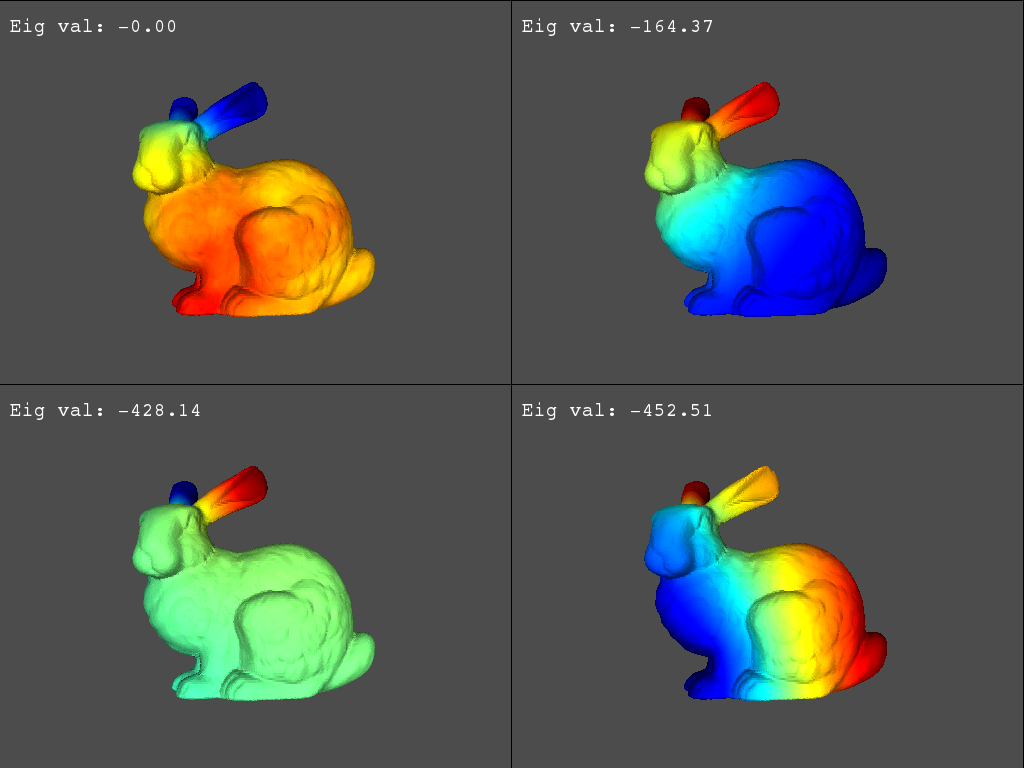

In [8]:
plotter = vtki.Plotter(shape=(2, 2))
plotter.view_vector([0,0,1], viewup = [0,1,0])

color_map = 'jet'


plotter.subplot(0,0)
polydata = PolyData(bunny.vertices, np.c_[[[3]]*len(bunny.triangles),bunny.triangles])
plotter.add_text('Eig val: {:.2f}'.format(final_val[4]), position=None, font_size=20)
plotter.add_mesh(polydata, scalars = final_vec[:,4], cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])


plotter.subplot(0, 1)
polydata = PolyData(bunny.vertices, np.c_[[[3]]*len(bunny.triangles),bunny.triangles])
plotter.add_text('Eig val: {:.2f}'.format(final_val[3]), position=None, font_size=20)
plotter.add_mesh(polydata, scalars = final_vec[:,3], cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])
                 
plotter.subplot(1,0)
polydata = PolyData(bunny.vertices, np.c_[[[3]]*len(bunny.triangles),bunny.triangles])
plotter.add_text('Eig val: {:.2f}'.format(final_val[2]), position=None, font_size=20)
plotter.add_mesh(polydata, scalars = final_vec[:,2], cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])


plotter.subplot(1, 1)
polydata = PolyData(bunny.vertices, np.c_[[[3]]*len(bunny.triangles),bunny.triangles])
plotter.add_text('Eig val: {:.2f}'.format(final_val[1]), position=None, font_size=20)
plotter.add_mesh(polydata, scalars = final_vec[:,1], cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])



plotter.show()

Although this looks cool, we will look at the sphere to be able to compare the discrete version with known results

# Examples

To show how the eigenfunction look like we will regards the sphere, since the eigenfunctions are known for this manifold. These are called the [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics).

## The exact case

To work with the sphere we need the sperical coordinates 
\begin{align*}
(x,y,z) = (\sin(\theta)\cos(\phi), \sin(\theta)\sin(\phi), \cos(\theta))
\end{align*}
With $\theta \in [0,\pi]$ and $\phi \in [-\pi, \pi]$, we assume $r=1$.


Then the eigenfunction can be written down as
\begin{align*}
\cos (m \phi) P_{l}^{m}(\cos \theta) \text{ and }\sin (m \phi) P_{l}^{m}(\cos \theta)
\end{align*}

With $l \in \{0,1,2,...\}$ and $m\in \{0,1,...,l\}$ with eigenvalue $\lambda = l(l+1)$. Below I will only regard the first, since the second is simply a rotation in the $z$ axis.
The function $P_l^m$ are the assiociated legendre polynomials.
$$
P_{l}^{m}(x) = \left(1-x^{2}\right)^{m / 2} \frac{d^{m}}{d x^{m}} P_{l}(x)
$$
Where $P_n$ are the legendre polynomials,
\begin{align*}
P_0 = 1, P_1 = x, P_2 = \frac{1}{2}(3x^2 - 1)
\end{align*}
Higher order polynomial can be generated recursively $(n+1) P_{n+1}(x)=(2 n+1) x P_{n}(x)-n P_{n-1}(x)$

To not have to calculate the derivatives by hand we use the autograd from pytorch. 

In [9]:
import torch
from torch.autograd import grad

def legrandre_polynomial(x, l):
    if l == 0:
        return 1
    elif l == 1:
        return x
    else:
        return 1/l*( (2*l-1)*x*legrandre_polynomial(x, l-1) - (l-1)*legrandre_polynomial(x,l-2))

    
def nth_derivative(f, wrt, n):
    if n == 0:
        return f
    else:
        f = f.sum()
    for _ in range(n):

        grads = grad(f, wrt, create_graph=True)[0]

        f = grads.sum()
    return grads

def Pml(x,m,l):
    x_torch = torch.Tensor(x)
    x_torch.requires_grad_()

    P_l = legrandre_polynomial(x_torch, l)

    dp_l = nth_derivative(P_l,x_torch,m)

    return ( ((1-x_torch**2)**(m/2)) *dp_l).detach().numpy()

def harmonic(theta, phi, m, l):
    cos_theta = np.cos(theta)
    P = Pml(cos_theta, m, l)
    return np.cos(m*phi)*P

In [10]:
sphere = read_ply('../test_data/sphere_uv_40k_new.ply')

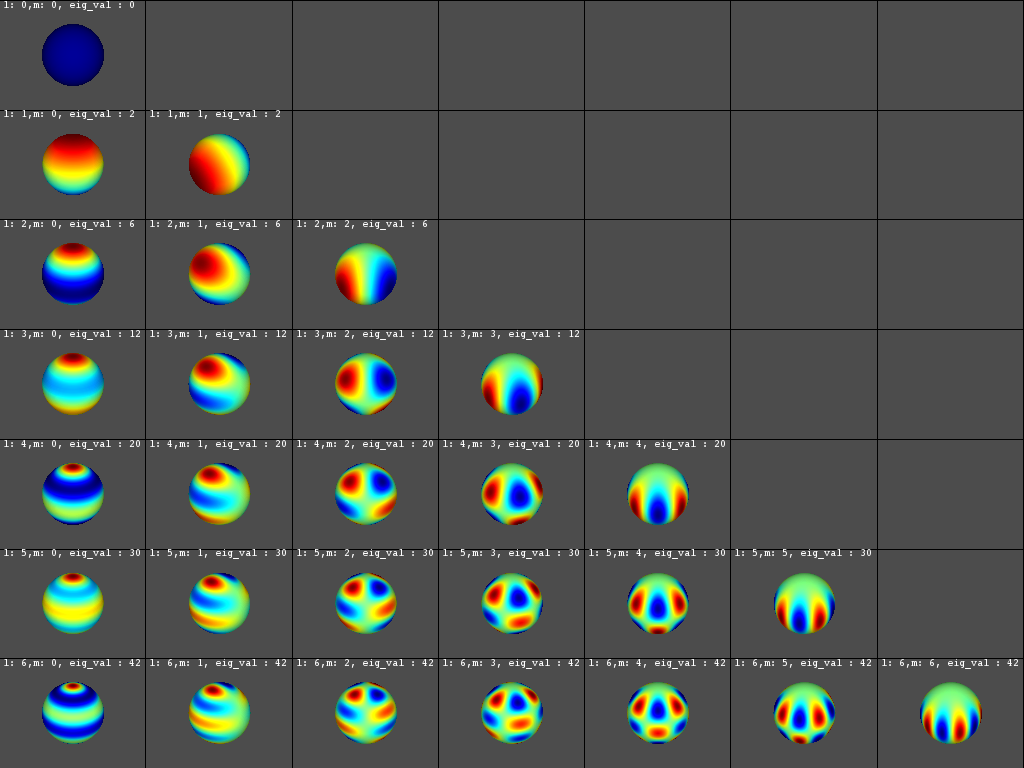

In [11]:
color_map = 'jet'

theta = np.arccos(sphere.vertices[:,2])
phi = np.arctan2(sphere.vertices[:,1], sphere.vertices[:,0])
L = 7
plotter = vtki.Plotter(shape = (L,L))
for l in range(L):
    for m in range(l+1):
        eig = harmonic(theta,phi, m = m, l= l)
        plotter.subplot(l,m)
        polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
        plotter.add_text('l: {},m: {}, eig_val : {}'.format(l,m, l*(l+1)), font_size=10)
        plotter.add_mesh(polydata, scalars = eig, cmap = color_map)


plotter.show()

## Numerical solutions

In [12]:
L, A = ddg.discrete_laplacian(sphere)
val, vec = sparse.linalg.eigsh(A, M=-L,k =50, which = 'LM', mode = 'buckling', sigma = -100)
sort = np.argsort(np.abs(val))[::-1] # reverse the sort to make is eventually smallest to biggest
val, vec = 1/val[sort], vec[:,sort]

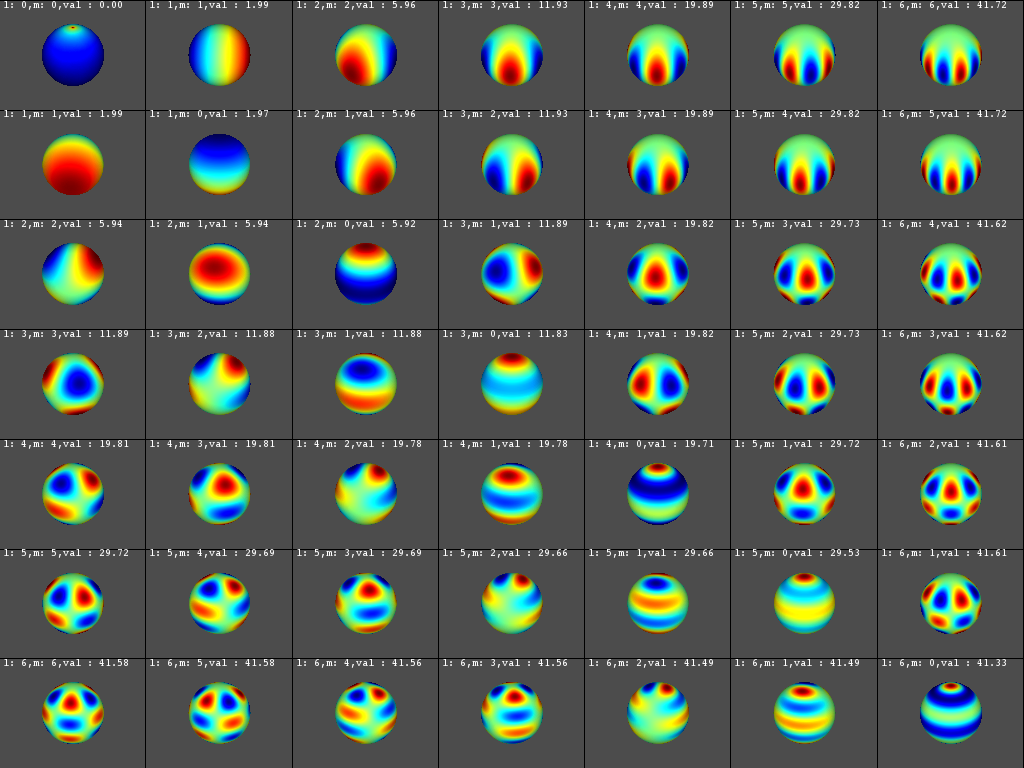

In [13]:
color_map = 'jet'

L = 7
plotter = vtki.Plotter(shape = (L,L))
for l in range(L):
    eig = vec[:,l**2]
    plotter.subplot(l,l)
    polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
    plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,0, val[l**2]), font_size=10)
    plotter.add_mesh(polydata, scalars = eig, cmap = color_map)

    for m in range(1,l+1):
        ind = m+(l)**2
        eig = vec[:,ind]
        plotter.subplot(l,l-m)
        polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
        plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,m, val[ind]), font_size=10)
        plotter.add_mesh(polydata, scalars = eig, cmap = color_map)
        
        ind = m+(l)**2+l
        eig = vec[:,ind]
        plotter.subplot(l-m,l)
        polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
        plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,m, val[ind]), font_size=10)
        plotter.add_mesh(polydata, scalars = eig, cmap = color_map)



plotter.show()

As you can see the eigen functions look similar, note that we now also have the rotated eigen functions. The eigenvalues deviate from the actual eigenvalues.



## Different triangulations

In [14]:
iso_sphere = read_ply('../test_data/sphere_iso_40k.ply')

In [15]:
L, A = ddg.discrete_laplacian(iso_sphere)
val, vec = sparse.linalg.eigsh(A, M=-L,k =50, which = 'LM', mode = 'buckling', sigma = -100)
sort = np.argsort(np.abs(val))[::-1] # reverse the sort to make is eventually smallest to biggest
val, vec = 1/val[sort], vec[:,sort]

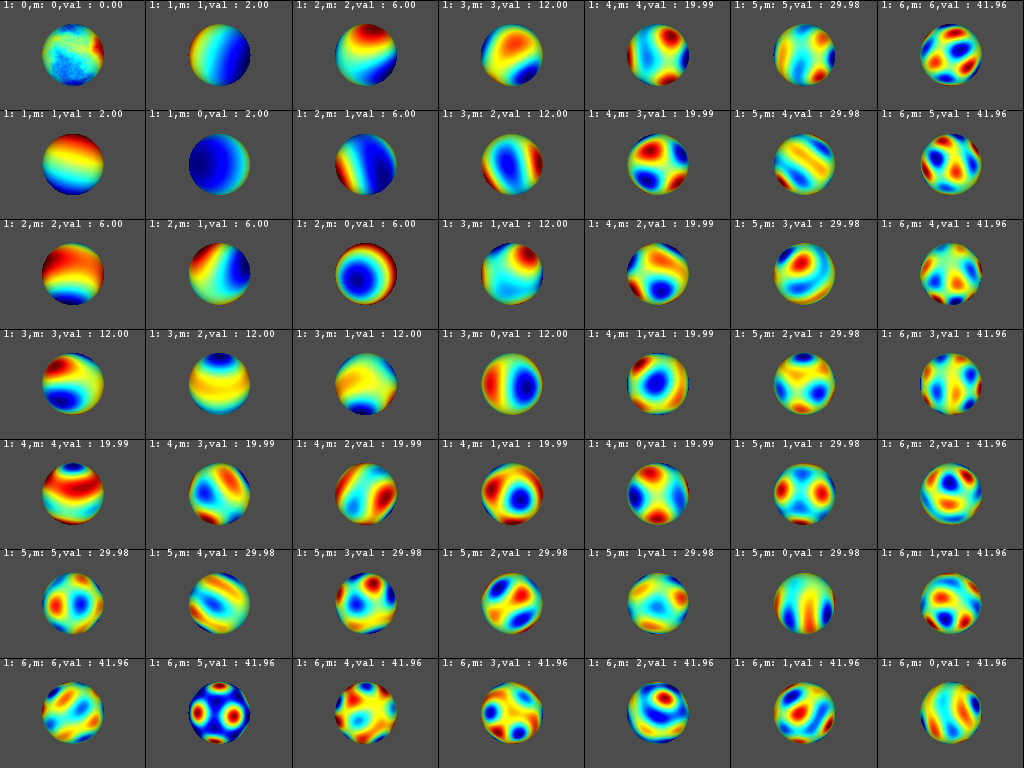

In [16]:
color_map = 'jet'

L = 7
plotter = vtki.Plotter(shape = (L,L))
for l in range(L):
    eig = vec[:,l**2]
    plotter.subplot(l,l)
    polydata = PolyData(iso_sphere.vertices, np.c_[[[3]]*len(iso_sphere.triangles),iso_sphere.triangles])
    plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,0, val[l**2]), font_size=10)
    plotter.add_mesh(polydata, scalars = eig, cmap = color_map)

    for m in range(1,l+1):
        ind = m+(l)**2
        eig = vec[:,ind]
        plotter.subplot(l,l-m)
        polydata = PolyData(iso_sphere.vertices, np.c_[[[3]]*len(iso_sphere.triangles),iso_sphere.triangles])
        plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,m, val[ind]), font_size=10)
        plotter.add_mesh(polydata, scalars = eig, cmap = color_map)
        
        ind = m+(l)**2+l
        eig = vec[:,ind]
        plotter.subplot(l-m,l)
        polydata = PolyData(iso_sphere.vertices, np.c_[[[3]]*len(iso_sphere.triangles),iso_sphere.triangles])
        plotter.add_text('l: {},m: {},val : {:.2f}'.format(l,m, val[ind]), font_size=10)
        plotter.add_mesh(polydata, scalars = eig, cmap = color_map)



plotter.show()

Many eigenfunctions we can match with ones from the UV-triangulation. But they are definitely different. Triangulations do seem to matter quite a bit.

The triangulations are both approximations of the sphere, but they are different approximations. The uv-sphere has a larger symmetry group than the iso-sphere, and symmetries are important for the harmonic functions, 

Furthermore the harmonic functions are assumed to be decomposable as $f(\phi, \theta) = f_1(\phi)f_2{\theta}$, the uv-sphere uses the same decomposition, that may be a reason why the uv-sphere is more similar to the exact case.

Finally, the eigenvalues of the iso-sphere are closer to the exact eigenvalues. 